# **Messi outlier**
## Goalscoring

The aim of this notebook is to assess whether Messi’s goalscoring performance can be considered an outlier when compared to other top goalscorers.

### Datasets
We use `dataset2_player_performances.parquet` & `dataset2_player_profiles`

- `dataset2_player_performances.parquet`: provides football player performances
- `dataset2_player_profiles`: provides football player names and other personal attributes

We merge the performance and profiles dataset using player_id as link

**Resulting dataset: `merged_player_data.parquet`**

In [1]:
import pandas as pd

# Load datasets (go up one level from notebooks/ to reach data/)
df_perf = pd.read_parquet("../data/dataset2_player_performances.parquet")
df_profiles = pd.read_parquet("../data/dataset2_player_profiles.parquet")

# Merge on player_id
df_merged = df_perf.merge(df_profiles, on="player_id", how="left")

# Save the merged dataset back into data/ or notebooks/
df_merged.to_parquet("../data/merged_player_data.parquet", index=False)

### We now focus on `goals` variable

In [3]:
import pandas as pd

# Load merged dataset
df_merged = pd.read_parquet("../data/merged_player_data.parquet")

# Aggregate total goals per player and sort
top_scorers = (
    df_merged.groupby("player_name", as_index=False)["goals"]
    .sum()
    .sort_values("goals", ascending=False)
)

# Shape of the aggregated data
print("Shape (rows, columns):", top_scorers.shape)

# Show the first rows
top_scorers.head(20)

Shape (rows, columns): (87891, 2)


,player_name,goals
15601,Cristiano Ronaldo (8198),796.0
47961,Lionel Messi (28003),771.0
70895,Robert Lewandowski (38253),610.0
50157,Luis Suárez (44352),509.0
86740,Zlatan Ibrahimović (3455),496.0
44032,Karim Benzema (18922),461.0
33900,Hulk (80562),434.0
21877,Edinson Cavani (48280),400.0
32950,Harry Kane (132098),398.0
75301,Sergio Agüero (26399),385.0


## Building the Goalscoring Viz

### 1) Data prep chunk

In [4]:
import numpy as np
import pandas as pd

# --- Load & aggregate (career totals per player) ---
df_merged = pd.read_parquet("../data/merged_player_data.parquet")

agg_all = (
    df_merged.groupby("player_name", as_index=False)[["goals","assists"]]
             .sum()
             .rename(columns={"goals":"value"})
)
agg_all["ga_total"] = agg_all["value"] + agg_all["assists"]
agg_goals = agg_all[agg_all["value"] > 0].copy()  # All goalscorers (≥1 goal)

# --- Find Messi (handles optional id suffix like " (28003)") ---
m = agg_all["player_name"].str.contains(r"^Lionel Messi(?:\s*\(\d+\))?$",
                                        case=False, na=False)
messi_name = agg_all.loc[m, "player_name"].iloc[0] if m.any() else None

# --- Cohorts: Top-N goalscorers across ALL players ---
def topN_goalscorers(df_agg: pd.DataFrame, N: int) -> pd.DataFrame:
    top_names = set(df_agg.sort_values("value", ascending=False).head(N)["player_name"])
    if messi_name is not None:
        top_names.add(messi_name)  # force-include Messi
    return df_agg[df_agg["player_name"].isin(top_names)].copy()

agg_top1000 = topN_goalscorers(agg_all, 1000)
agg_top500  = topN_goalscorers(agg_all, 500)
agg_top100  = topN_goalscorers(agg_all, 100)
agg_top10   = topN_goalscorers(agg_all, 10)

# --- Build combined DF with row labels ---
def prep_block(df: pd.DataFrame, row_label: str) -> pd.DataFrame:
    out = df.loc[:, ["player_name", "value"]].copy()
    out["row"] = row_label
    out["is_messi"] = (out["player_name"] == messi_name)
    return out

df_plot = pd.concat(
    [
        prep_block(agg_goals,   "All goalscorers"),
        prep_block(agg_top1000, "Top-1000 goalscorers"),
        prep_block(agg_top500,  "Top-500 goalscorers"),
        prep_block(agg_top100,  "Top-100 goalscorers"),
        prep_block(agg_top10,   "Top-10 goalscorers"),
    ],
    ignore_index=True
)

# --- Jitter column for background dots (ONLY for plotting) ---
rng = np.random.default_rng(123)
mask_other = ~df_plot["is_messi"]
df_plot.loc[mask_other, "value_jit"] = (
    df_plot.loc[mask_other, "value"] + rng.uniform(-0.3, 0.3, mask_other.sum())
)
df_plot.loc[~mask_other, "value_jit"] = df_plot.loc[~mask_other, "value"]

### 2) Viz chunk

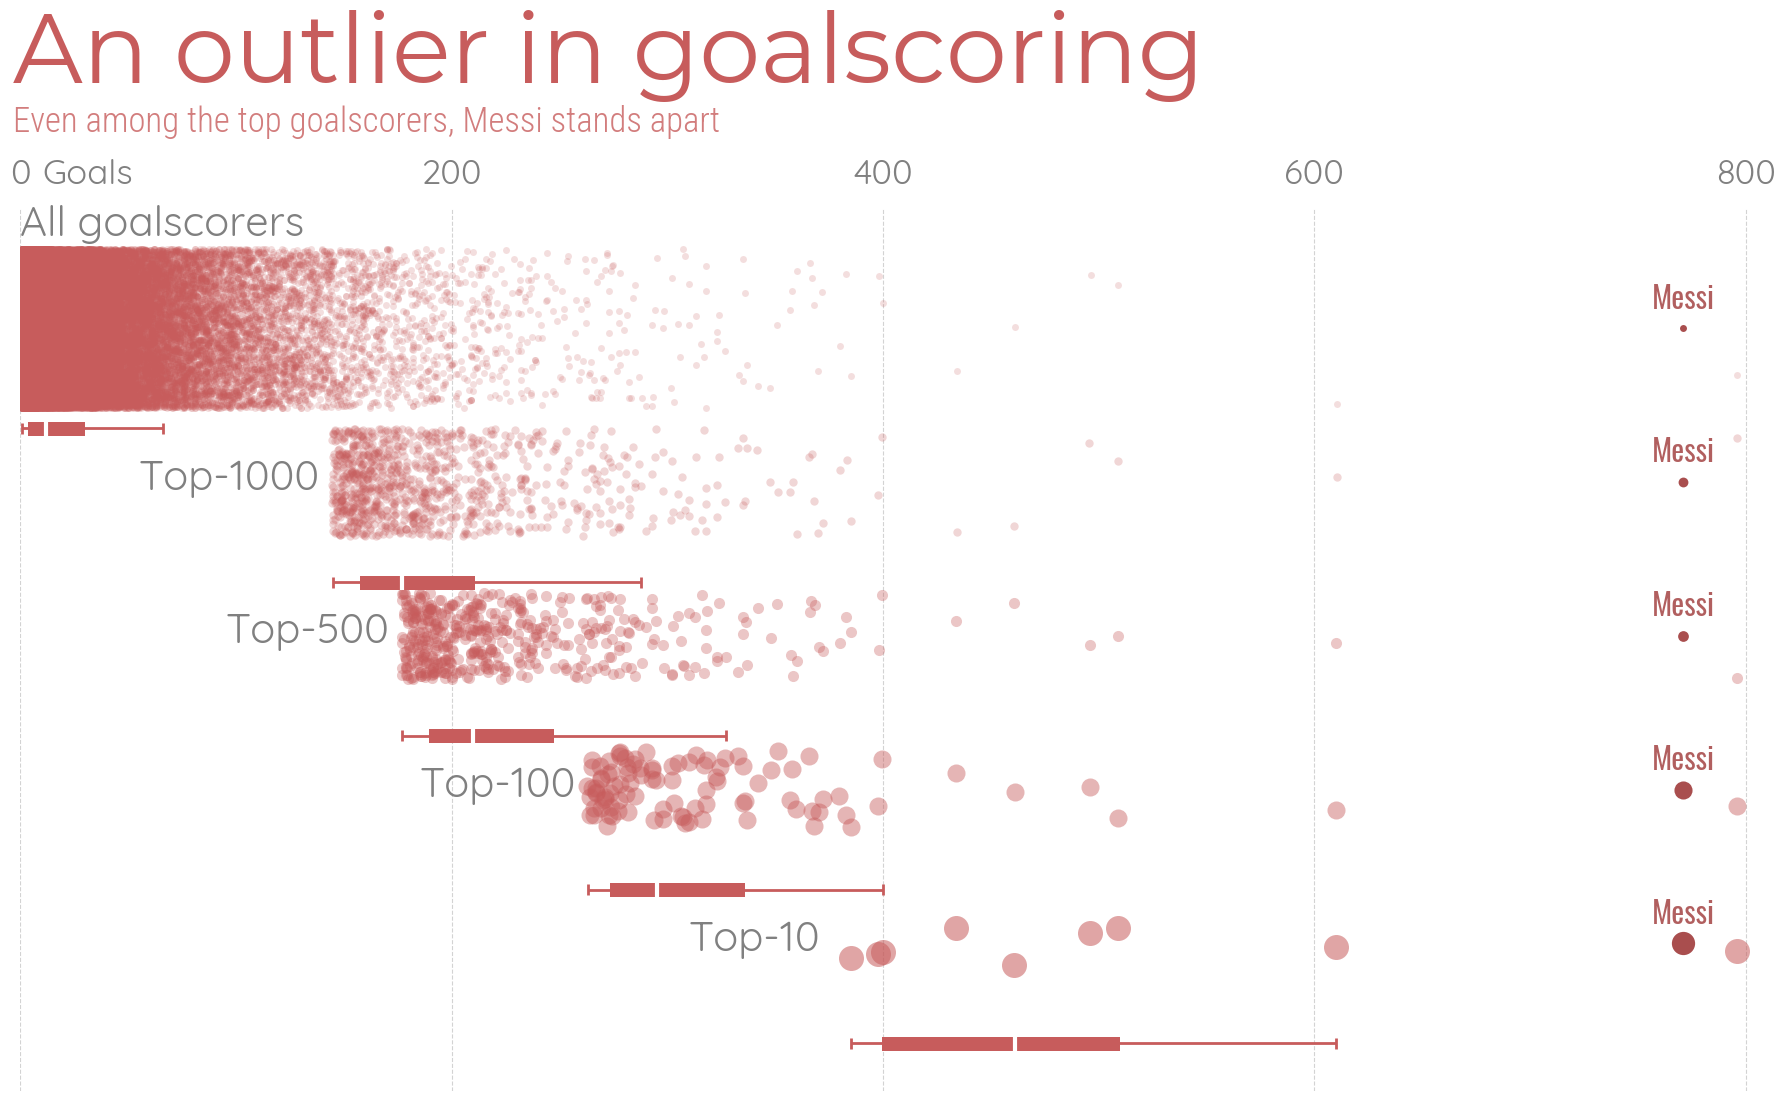

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

from pyfonts import load_font
# Fonts (for labels/title)
oswald = load_font("https://github.com/google/fonts/raw/main/ofl/oswald/Oswald%5Bwght%5D.ttf")
quick_reg = load_font("/Users/andresdevegili/Documents/fonts/Quicksand/static/Quicksand-Regular.ttf")
montserrat_reg = load_font("/Users/andresdevegili/Documents/fonts/Montserrat/static/Montserrat-Regular.ttf")
instrument = load_font("https://github.com/google/fonts/raw/main/ofl/instrumentserif/InstrumentSerif-Regular.ttf")
roboto_cond_light = load_font("/Users/andresdevegili/Documents/fonts/Roboto/static/Roboto_Condensed-Light.ttf")

DARK_PALE_RED = "#c75c5c"

# Per-row visual arguments
row_styles = {
    "All\ngoalscorers":       {"size": 5,   "alpha": 0.2,  "messi_size": 25,  "jitter": 0.52},
    "Top-1000\ngoalscorers":  {"size": 6,   "alpha": 0.25, "messi_size": 50,  "jitter": 0.35},
    "Top-500\ngoalscorers":   {"size": 8,   "alpha": 0.35, "messi_size": 60,  "jitter": 0.28},
    "Top-100\ngoalscorers":   {"size": 13,  "alpha": 0.45, "messi_size": 170, "jitter": 0.25},
    "Top-10\ngoalscorers":    {"size": 18,"alpha": 0.55, "messi_size": 280, "jitter": 0.15},
}

def shade(hex_color, factor=0.85):
    import numpy as np
    rgb = np.array(mcolors.to_rgb(hex_color))
    return tuple(np.clip(rgb * factor, 0, 1))

messi_color = shade(DARK_PALE_RED, 0.85)

def add_thin_boxplot(ax, values, yidx,
                     facecolor="#c75c5c", edgecolor="#c75c5c",
                     alpha=1, height=0.07,
                     whisker_lw=2, median_lw=3, cap_frac=1):
    import numpy as np
    vals = np.asarray(values)
    if vals.size == 0:
        return
    q1, med, q3 = np.percentile(vals, [25, 50, 75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    whislo = vals[vals >= lo].min(initial=q1)
    whishi = vals[vals <= hi].max(initial=q3)

    y  = yidx + 0.65
    y0 = y - height/2.0
    y1 = y + height/2.0

    rect = Rectangle((q1, y0), q3 - q1, height,
                     facecolor=facecolor, edgecolor=edgecolor,
                     linewidth=whisker_lw, zorder=4)
    rect.set_alpha(alpha)
    rect.set_antialiased(False)
    ax.add_patch(rect)

    ax.hlines(y, whislo, whishi, color=edgecolor, linewidth=whisker_lw, zorder=4)

    cap_len = height * cap_frac
    cap_y0, cap_y1 = y - cap_len/2.0, y + cap_len/2.0
    ax.vlines([whislo, whishi], cap_y0, cap_y1, color=edgecolor, linewidth=whisker_lw, zorder=4)

    ax.vlines(med, y0 - height*0.2, y1 + height*0.2, color="white", linewidth=median_lw, zorder=5)

# --- Plot ---
fig, ax = plt.subplots(figsize=(18, 10))

for row_label, style in row_styles.items():
    sub = df_plot[(~df_plot["is_messi"]) & (df_plot["row"] == row_label)]
    sns.stripplot(
        data=sub,
        x="value_jit", y="row",
        order=list(row_styles.keys()),
        color=DARK_PALE_RED,
        size=style["size"], alpha=style["alpha"],
        jitter=style["jitter"], dodge=False, ax=ax
    )

    # Messi overlay
    messi_sub = df_plot[(df_plot["is_messi"]) & (df_plot["row"] == row_label)]
    if not messi_sub.empty:
        ax.scatter(
            messi_sub["value"], messi_sub["row"],
            s=style["messi_size"], c=[messi_color], zorder=3, linewidths=0
        )
        for x, row_lab in zip(messi_sub["value"], messi_sub["row"]):
            ax.annotate(
                "Messi", xy=(x, row_lab),
                xytext=(0, 10), textcoords="offset points",
                ha="center", va="bottom",
                color=messi_color, fontsize=22, fontproperties=oswald, alpha=0.9,
                clip_on=False
            )

    # Thin filled boxplot overlay
    if not sub.empty:
        yidx = list(row_styles.keys()).index(row_label)
        add_thin_boxplot(
            ax, sub["value"].to_numpy(), yidx,
            facecolor=DARK_PALE_RED, edgecolor=DARK_PALE_RED,
            alpha=1, height=0.07, whisker_lw=2, median_lw=3, cap_frac=1
        )

# Axes & grid (linear)
ax.set_xlim(0, 810)
ax.set_xlabel(""); ax.set_ylabel(""); ax.set_title("")
ticks = [0, 200, 400, 600, 800]

# vertical grid lines at tick positions
xmin, xmax = ax.get_xlim(); eps = (xmax - xmin) * 1e-3
for xpos in ticks:
    xx = xpos - eps if np.isclose(xpos, xmax) else xpos
    ax.axvline(xx, color="lightgray", linestyle="--", linewidth=0.8, zorder=0)

# Hide default tick labels
ax.set_xticks(ticks)
ax.set_xticklabels([])

# Custom centered labels
custom_labels = ["0", "200", "400", "600", "800"]
for xpos, label in zip(ticks, custom_labels):
    ax.text(
        xpos, 1.02, label,
        ha="center", va="bottom",
        transform=ax.get_xaxis_transform(),
        fontproperties=quick_reg, fontsize=25, color="gray"
    )

# Add "Goals" next to the zero
ax.text(
    0 + 10, 1.02, "Goals",   # adjust +45 to control spacing
    ha="left", va="bottom",
    transform=ax.get_xaxis_transform(),
    fontproperties=quick_reg, fontsize=25, color="gray"
)

# Top label
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()

# Tick styling
for lab in ax.get_xticklabels():
    lab.set_fontproperties(quick_reg); lab.set_fontsize(18); lab.set_color("gray")

# Clean look
for spine in ax.spines.values(): spine.set_visible(False)
ax.tick_params(axis="x", bottom=False, labelbottom=False, top=True, labeltop=True, length=0)
ax.tick_params(axis="y", left=False, labelleft=False, length=0)
ax.set_yticklabels([])

# Custom row labels with manual positioning
custom_positions = {
    "All goalscorers":      {"x": 0, "y": -0.55},   
    "Top-1000":             {"x": 55, "y": 1.1},
    "Top-500":              {"x": 95, "y": 2.1},
    "Top-100":              {"x": 185, "y": 3.1},
    "Top-10":               {"x": 310, "y": 4.1},
}

for label, pos in custom_positions.items():
    ax.text(
        pos["x"], pos["y"],
        s=label,
        ha="left", va="bottom",
        fontproperties=quick_reg, fontsize=30, color="gray"
    )

# Title & Subtitle
fig.text(0.01, 1.004, "An outlier in goalscoring",
         fontproperties=montserrat_reg, fontsize=70, color=DARK_PALE_RED,
         ha="left", va="bottom")
fig.text(0.01, 1.001, "Even among the top goalscorers, Messi stands apart",
         fontproperties=roboto_cond_light, fontsize=25, color=DARK_PALE_RED, alpha=0.8,
         ha="left", va="top")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("../figs/Messi_outlier_GOALS_top500_100_10.png", dpi=200, bbox_inches="tight")
plt.savefig("../figs/Messi_outlier_GOALS_top500_100_10.svg", bbox_inches="tight")
plt.show()